# Binary Customer Churn

### Problem Statement
--------------------------
A marketing agency has many customers that use their service to produce ads for the client/customer websites. They've noticed that they have quite a bit of churn in clients. They basically randomly assign account managers right now, but want you to create a machine learning model that will help predict which customers will churn (stop buying their service) so that they can correctly assign the customers most at risk to churn an account manager. 


They have some historical data, can you help them out? 

Create a classification model (using the Historical data in customer_churn.csv) that will help classify whether or not a customer churned. Then the company can test this against incoming data for future customers to predict which customers will churn and assign them an account manager.

The data is saved as customer_churn.csv. Here are the fields and their definitions:

    Name : Name of the latest contact at Company
    Age: Customer Age
    Total_Purchase: Total Ads Purchased
    Account_Manager: Binary 0=No manager, 1= Account manager assigned
    Years: Totaly Years as a customer
    Num_sites: Number of websites that use the service.
    Onboard_date: Date that the name of the latest contact was onboarded
    Location: Client HQ Address
    Company: Name of Client Company
    
Once model is created and evaluated it, test out the model on some new data (think of this almost like a hold-out set) that your client has provided, saved under new_customers.csv. The client wants to know which customers are most likely to churn given this data (they don't have the label yet).



### Create Spark Session

In [2]:
from pyspark.sql import SparkSession

In [3]:
sessn = SparkSession.builder.appName('LogisticRegressionProj').getOrCreate()

In [4]:
sessn

### Read csv File and display information about Dataset

In [5]:
csv_data = sessn.read.csv(path='customer_churn.csv',inferSchema=True,header=True)

In [7]:
csv_data.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'Churn']

In [8]:
len(csv_data.columns)

10

In [9]:
csv_data.count()

900

In [10]:
csv_data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [14]:
csv_data.show(5)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|  Cynthia Norton|37.0|    

In [15]:
csv_data['Age','Total_Purchase','Account_Manager','Years','Num_Sites','Onboard_date','Location', 'Company', 'Churn'].show()

+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|37.0|       9191.58|              0| 5.56|      9.0|2016-01-19 15:31:15|765 Tricia Row Ka...|          Love-Jones|    1|
|48.0|      10356.02|   

In [16]:
csv_data['Age','Total_Purchase','Account_Manager','Years','Num_Sites','Onboard_date','Location', 'Company', 'Churn'].describe().show()

+-------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|summary|              Age|   Total_Purchase|   Account_Manager|            Years|         Num_Sites|            Location|             Company|              Churn|
+-------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+--------------------+-------------------+
|  count|              900|              900|               900|              900|               900|                 900|                 900|                900|
|   mean|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|                null|                null|0.16666666666666666|
| stddev|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969|                null|                null| 0.3728852122772358|
|    min|       

###### Note that from above output it is evident that Null value is not present in any of the Features.

In [25]:
refined_data = csv_data['Age','Total_Purchase','Years','Num_Sites','Churn']

In [26]:
refined_data.count()

900

In [27]:
refined_data.columns

['Age', 'Total_Purchase', 'Years', 'Num_Sites', 'Churn']

### Convert data tO MlLib FORMAT USING VectorAssembler

In [28]:
from pyspark.ml.feature import VectorAssembler

In [29]:
assembler = VectorAssembler(inputCols=['Age', 'Total_Purchase', 'Years', 'Num_Sites'],
                            outputCol='features'
                           )

In [30]:
mllib_data = assembler.transform(refined_data)

In [32]:
mllib_data.show(5)

+----+--------------+-----+---------+-----+--------------------+
| Age|Total_Purchase|Years|Num_Sites|Churn|            features|
+----+--------------+-----+---------+-----+--------------------+
|42.0|       11066.8| 7.22|      8.0|    1|[42.0,11066.8,7.2...|
|41.0|      11916.22|  6.5|     11.0|    1|[41.0,11916.22,6....|
|38.0|      12884.75| 6.67|     12.0|    1|[38.0,12884.75,6....|
|42.0|       8010.76| 6.71|     10.0|    1|[42.0,8010.76,6.7...|
|37.0|       9191.58| 5.56|      9.0|    1|[37.0,9191.58,5.5...|
+----+--------------+-----+---------+-----+--------------------+
only showing top 5 rows



In [33]:
mllib_data.count()

900

In [34]:
mllib_data.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- features: vector (nullable = true)



In [35]:
mllib_data.head(5)

[Row(Age=42.0, Total_Purchase=11066.8, Years=7.22, Num_Sites=8.0, Churn=1, features=DenseVector([42.0, 11066.8, 7.22, 8.0])),
 Row(Age=41.0, Total_Purchase=11916.22, Years=6.5, Num_Sites=11.0, Churn=1, features=DenseVector([41.0, 11916.22, 6.5, 11.0])),
 Row(Age=38.0, Total_Purchase=12884.75, Years=6.67, Num_Sites=12.0, Churn=1, features=DenseVector([38.0, 12884.75, 6.67, 12.0])),
 Row(Age=42.0, Total_Purchase=8010.76, Years=6.71, Num_Sites=10.0, Churn=1, features=DenseVector([42.0, 8010.76, 6.71, 10.0])),
 Row(Age=37.0, Total_Purchase=9191.58, Years=5.56, Num_Sites=9.0, Churn=1, features=DenseVector([37.0, 9191.58, 5.56, 9.0]))]

#### We need to select the 'features' and label ('Churn') column from the Vecotrized Dataset

In [36]:
final_mllib_data = mllib_data['features','Churn']

In [39]:
final_mllib_data.show(5)

+--------------------+-----+
|            features|Churn|
+--------------------+-----+
|[42.0,11066.8,7.2...|    1|
|[41.0,11916.22,6....|    1|
|[38.0,12884.75,6....|    1|
|[42.0,8010.76,6.7...|    1|
|[37.0,9191.58,5.5...|    1|
+--------------------+-----+
only showing top 5 rows



In [40]:
final_mllib_data.count()

900

### Train Test Split

In [41]:
train_data,test_data = final_mllib_data.randomSplit([0.7,0.3])

In [43]:
train_data.count()

630

In [44]:
test_data.count()

270

### Build Logistic Regression Model

In [45]:
from pyspark.ml.classification import LogisticRegression

In [46]:
LR_ob = LogisticRegression(featuresCol='features',labelCol='Churn',)

In [47]:
LRModel = LR_ob.fit(train_data)

In [48]:
LRModel.coefficients

DenseVector([0.0744, 0.0, 0.6086, 1.1712])

### Evaluate the Linear Regression Model

In [50]:
pred = LRModel.evaluate(test_data)

In [51]:
pred.areaUnderROC

0.921158487530169

In [52]:
pred.accuracy

0.9074074074074074

In [53]:
pred.precisionByLabel

[0.9313304721030042, 0.7567567567567568]

In [55]:
pred.predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[26.0,8939.61,4.5...|    0|[6.27842819064711...|[0.99812716654822...|       0.0|
|[28.0,8670.98,3.9...|    0|[7.64457069560212...|[0.99952159323609...|       0.0|
|[29.0,5900.78,5.5...|    0|[4.36555945518782...|[0.98745191150041...|       0.0|
|[29.0,8688.17,5.7...|    1|[3.01530646414131...|[0.95326085118478...|       0.0|
|[29.0,9378.24,4.9...|    0|[4.63187971155533...|[0.99035744397852...|       0.0|
|[29.0,12711.15,5....|    0|[5.19790557989022...|[0.99450226168290...|       0.0|
|[29.0,13240.01,4....|    0|[7.05725440427168...|[0.99913960173140...|       0.0|
|[30.0,10744.14,7....|    1|[1.98313816387622...|[0.87901529484427...|       0.0|
|[31.0,7073.61,5.7...|    0|[2.90258964160412...|[0.94797430378178...|       0.0|
|[31.0,8829.83,4

In [56]:
pred.recallByLabel

[0.9601769911504425, 0.6363636363636364]

In [62]:
x = pred.roc

In [65]:
df = x.toPandas()

In [66]:
type(df)

pandas.core.frame.DataFrame

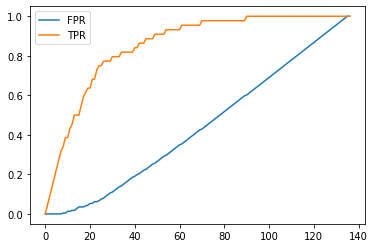

In [67]:
df.plot()

### Apply the Model on Incoming Data

In [68]:
new_cust_csv_data = sessn.read.csv(path='new_customers.csv',header=True,inferSchema=True)

In [69]:
new_cust_csv_data.count()

6

In [70]:
new_cust_csv_data.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company']

In [71]:
new_cust_mllib_data = assembler.transform(new_cust_csv_data)

In [72]:
new_cust_mllib_data.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- features: vector (nullable = true)



In [73]:
new_cust_mllib_data.show()

+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+--------------------+
|         Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|         Company|            features|
+--------------+----+--------------+---------------+-----+---------+-------------------+--------------------+----------------+--------------------+
| Andrew Mccall|37.0|       9935.53|              1| 7.71|      8.0|2011-08-29 18:37:54|38612 Johnny Stra...|        King Ltd|[37.0,9935.53,7.7...|
|Michele Wright|23.0|       7526.94|              1| 9.28|     15.0|2013-07-22 18:19:54|21083 Nicole Junc...|   Cannon-Benson|[23.0,7526.94,9.2...|
|  Jeremy Chang|65.0|         100.0|              1|  1.0|     15.0|2006-12-11 07:48:13|085 Austin Views ...|Barron-Robertson|[65.0,100.0,1.0,1...|
|Megan Ferguson|32.0|        6487.5|              0|  9.4|     14.0|2016-10-28 05:32:13|922 Wright Branch...|   

In [75]:
#Make the Logistic Regression Classification model on complete Source Data (with 900 observations)
LRModel_FullDS = LR_ob.fit(final_mllib_data)

In [77]:
new_cust_pred = LRModel_FullDS.transform(new_cust_mllib_data)

In [79]:
new_cust_pred.columns

['Names',
 'Age',
 'Total_Purchase',
 'Account_Manager',
 'Years',
 'Num_Sites',
 'Onboard_date',
 'Location',
 'Company',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

In [81]:
new_cust_pred['Names', 'Company','Age','Years','Total_Purchase','Num_Sites','prediction'].show()

+--------------+----------------+----+-----+--------------+---------+----------+
|         Names|         Company| Age|Years|Total_Purchase|Num_Sites|prediction|
+--------------+----------------+----+-----+--------------+---------+----------+
| Andrew Mccall|        King Ltd|37.0| 7.71|       9935.53|      8.0|       0.0|
|Michele Wright|   Cannon-Benson|23.0| 9.28|       7526.94|     15.0|       1.0|
|  Jeremy Chang|Barron-Robertson|65.0|  1.0|         100.0|     15.0|       1.0|
|Megan Ferguson|   Sexton-Golden|32.0|  9.4|        6487.5|     14.0|       1.0|
|  Taylor Young|        Wood LLC|32.0| 10.0|      13147.71|      8.0|       0.0|
| Jessica Drake|   Parks-Robbins|22.0| 3.46|       8445.26|     14.0|       1.0|
+--------------+----------------+----+-----+--------------+---------+----------+

